In [11]:
# Use svg graphics, display inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
import os

# Basic scientific computing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# display config
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.options.display.max_rows = 999
plt.style.use('default')
plt.rcParams['figure.figsize'] = 10, 6
plt.style.use('ggplot')
np.set_printoptions(suppress=True)


from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin

print(sys.version)

3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]


Helper functions

In [12]:
def gen_dump_urls(dir_url):
    
    '''
    Yields a generator that returns urls to each language direction's
    translation data for a given week's directions
    '''

    response = requests.get(dir_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    for link in soup.find_all('a'):
        file_name = link.get('href')
        if '_' not in file_name and 'text.json' in file_name:
            yield urljoin(dir_url, file_name)


def get_dump_dir_urls():
    
    '''
    Yields a generator that returns directories containing a given
    week's worth of translation data (cumulative)
    '''
    
    ROOT_PATH = 'https://dumps.wikimedia.org/other/contenttranslation/'
    response = requests.get(ROOT_PATH)
    soup = BeautifulSoup(response.text, 'html.parser')

    links = soup.find_all('a')
    links.pop(0)   # first list isn't relevant
    
    for path in links:
        yield urljoin(ROOT_PATH, path.get('href'))
        
def get_latest_dump_set():
    return list(get_dump_dir_urls())[-1]

def get_engine(data_dict):
    if not isinstance(data_dict, dict) or not data_dict:
        return None
    return data_dict.get('engine', None)

def get_text_from_dict(content_dict):
    if content_dict and isinstance(content_dict, dict):
        return content_dict.get('content', None)
    return None

def is_relevant_file(filename, target_langs):
    '''
    Filters urls, returning True if the url is for a given target language
    '''
    relevant_directions = set([f'en2{lang}' for lang in target_langs])
    is_relevant = any(direction in filename for direction in relevant_directions)

    return is_relevant and 'text.json' in filename


def format_df(df):
    '''
    Extracts text from nested dicts, cleans up column names
    '''
    
    df_out = (df
        .rename(columns={
            'sourceLanguage': 'source_language',
            'targetLanguage': 'target_language'
        })
        .assign(
            translation_engine=lambda df_: df_.mt.apply(get_engine).str.lower(),
            id_for_join=lambda df_: df_.id.apply(lambda x: x.split('/')[0]),
            source=lambda df_: df_.source.apply(get_text_from_dict),
            mt=lambda df_: df_.mt.apply(get_text_from_dict),
            target=lambda df_: df_.target.apply(get_text_from_dict)
        )
    )
    
    return df_out

## Get the weekly cumulative data

In [14]:
df = pd.DataFrame()
first_flores_date = '20220218'

for dump_dir in get_dump_dir_urls():

    ds = dump_dir.split('/')[-2]
    for dump_url in gen_dump_urls(dump_dir):
        
        if not is_relevant_file(dump_url, target_langs) or ds < first_flores_date:
            continue

        df_volume = (
            pd.read_json(dump_url, compression='gzip')
            .pipe(lambda df_raw: format_df(df_raw))
            .query('translation_engine == "flores"')
            .groupby(['target_language', 'translation_engine'])
            .id
            .agg([('total_translations', len)])
            .reset_index()
            .assign(ds=ds)
        )

        df = pd.concat([df, df_volume])
    print(f'finished {ds}')

print('done!')

df = df.sort_values(['ds', 'target_language']).reset_index(drop=True)
df.head()

finished 20220107
finished 20220114
finished 20220121
finished 20220128
finished 20220204
finished 20220211
finished 20220218
finished 20220225
finished 20220304
finished 20220311
finished 20220318
finished 20220325
finished 20220401
finished 20220408
done!


,target_language,translation_engine,total_translations,ds
0,ig,flores,1,20220218
1,zh,flores,4,20220218
2,ig,flores,1,20220225
3,zh,flores,5,20220225
4,ig,flores,4,20220304


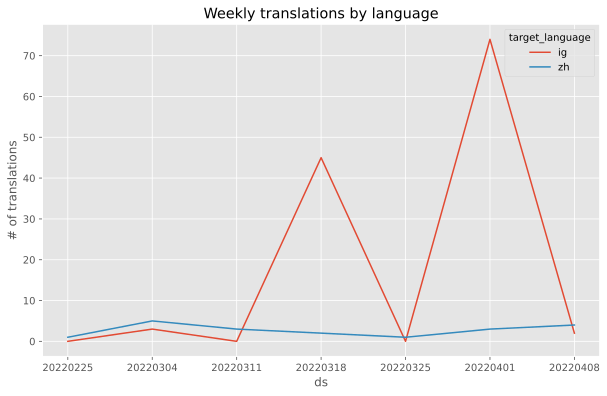

In [15]:
(df
    .pivot_table('total_translations', index='ds', columns='target_language')
    .pipe(lambda df_: df_ - df_.shift())   # don't want cumulative data
    .plot.line(
        title='Weekly translations by language', 
        ylabel='# of translations'
    )
);

In [16]:
(df
    .pivot_table('total_translations', index='ds', columns='target_language')
    .pipe(lambda df_: df_ - df_.shift())
    .dropna()
    .astype(int)
    .T
)

ds,20220225,20220304,20220311,20220318,20220325,20220401,20220408
target_language,,,,,,,
ig,0,3,0,45,0,74,2
zh,1,5,3,2,1,3,4
